**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/   
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
import gzip
import gc
import pickle
import matplotlib.pyplot as plt

In [2]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [4]:
neg = pd.read_csv('../data/text/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [5]:
pos = pd.read_csv('../data/text/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [6]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [7]:
%xdel neg
%xdel pos

In [8]:
data.sample(10)

,id,ttext,ttype
5157,409776908562608129,@wertlosesleben охренеть. просматриваю прайс пирсинга. ломают хрящ уха о_О,-1
107658,424263278970560514,Обувь новую купи - пятку до крови натри! ( http://t.co/rmg461Wcho,-1
69924,410464944845381633,Открыли с Ваней сезон вт теперь внотури зима началась!),1
90390,410843894432026624,@YourHighessEva ты недооцениваешь такую извращенку :D,1
19724,411534554852511744,RT @karina_8833: #ПредновогодниеОбнимашки \n@LETO_ON_MARS @FelixFelicis10 @Sonya_Swag @Angryartpencil @Nastya_Revenge @matissirina @I__…,-1
81057,419725038280265728,#ядовитые слова: надо покушать приготовить.(,-1
81423,419755135490088960,У Луишки бабушка умерла...фигово это так-то:(,-1
90677,410847656575909888,"Мне так нравится, что у нас так много снега, но и одновременно хочется лета :D",1
73725,418372349705355264,"RT @monucilewyke: Отличная мультиязычность в django-nani, одна проблема только — свежая версия обратно несовместима с предыдущими :-( Не то",-1
89205,421578540325146624,"как на улице холодно и мокро(\nне думала ,что зимой я приду с мокрыми волосами из-за дождя..",-1


## очистка данных

In [9]:
data['ttext_clean'] = data['ttext'].apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

In [10]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t  ]
  )

In [11]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ]
  )

In [12]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ]
  )

In [13]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ]
  )

In [14]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ]
  )

In [15]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ]
  )

In [16]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [17]:
data['ttext_clean'] = data['ttext_clean'].str.lower()
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'_', ' ', s))
data['ttext_clean'] = data['ttext_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s)) 


In [18]:
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

In [19]:
# замена буквенно-цифровых кодов
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ]
)

In [20]:
# data[['ttext_clean']]
# data[['ttext']]

---

In [21]:
# from nltk import download as nltk_download
# nltk_download('stopwords')

# from Stemmer import Stemmer

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [22]:
# with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
#     stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )

In [23]:
ppr(stopwords)

записей: 151


In [24]:
# удаление лишних слов
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[w for w in t if w not in stopwords])

In [25]:
%xdel stopwords

In [26]:
# %%time 

# from Stemmer import Stemmer
# # pacman -S python-pystemmer
# # pip install pystemmer

# # стемминг, выделение основы слова
# data['ttext_clean'] = data['ttext_clean'].apply( lambda t:Stemmer('russian').stemWords(t) )

In [27]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[w for w in t if len(w)>2])

---

In [28]:
# data[ data['ttext_clean'].str.len()<1 ][['ttext_clean']]

In [29]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 826


In [30]:
data.sample(3)

,id,ttext,ttype,ttext_clean
20673,409417302602285056,"2/2. Вам Собянин жижу разводит реагентами, а наш @VorobievAndrey шарит в зиме, поэтому у нас уже до асфальта не докопаешься:)",1,"[digit, digit, собянин, жижу, разводит, реагентами, наш, vorobievandrey, шарит, зиме, поэтому, асфальта, докопаешься, happysmile]"
125200,410404402038452224,@Niallsmile69 у меня ... ска такая бесит меня (,-1,"[ска, такая, бесит]"
160975,414678415933853696,@MedveedevaAl блин :((\nмне васю девать не куда,-1,"[medveedevaal, блин, sadsmile, васю, девать]"


## строим датасет

### дополняем и перестраиваем текст

In [31]:
# vocab = ['<PAD>','<START>','<UNK>'] + sorted(set([ w for t in data_train['ttext_clean'] for w in t if w ]))
# ppr(vocab)

In [34]:
data['ttext_clean'] = data['ttext_clean'].apply( lambda d: d+['<START>'] )

In [35]:
n_max = data['ttext_clean'].str.len().max()
n_max

31

In [36]:
pad = ['<PAD>']*n_max

In [37]:
data[['ttext_clean']].sample(3)

,ttext_clean
62947,"[funny, tea, дня, ходила, слушала, happysmile, <START>]"
83182,"[tasteyogurt, омг, большой, могущественный, словарный, запас, поражаешь, чувак, <START>]"
74761,"[алинка, заплела, вчера, колосок, второй, день, держится, разваливается, <START>]"


In [38]:
data['ttext_clean'] = data['ttext_clean'].apply(
    lambda t: pad[len(t):] + list(reversed(t)) 
  )

In [39]:
data[['ttext_clean']].sample(3)

,ttext_clean
151562,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, седня, полу..."
174356,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, sadsmile, м..."
147923,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <START>, реда, некоторых, ладно, редактором, просмотрщи..."


### кодируем word2vec

In [40]:
# %%time


# https://nlpub.ru/Russian_Distributional_Thesaurus
    
# from gensim.models import KeyedVectors 
# w2v_file = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
# w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True, unicode_errors='ignore')
# w2v.init_sims(replace=True)

In [44]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 256

w2v = Word2Vec( data['ttext_clean'].values, min_count=1, size=w2v_size, window=4, workers=4)

# with open('result/Word2Vec.pkl', 'wb') as f: pickle.dump(w2v, f)

CPU times: user 1min 6s, sys: 507 ms, total: 1min 7s
Wall time: 45.3 s


---

In [45]:
w2v_vocab = sorted([w for w in w2v.wv.vocab])
ppr(w2v_vocab)

записей: 239 404


In [46]:
ii = np.random.permutation(len(w2v_vocab))[:30]
for i in ii:
    w = w2v_vocab[i]
    ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]
    print( w,':',ww )

<ipython-input-46-51489ecf273e>:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]


руди : ['semko', 'оффлайне', 'abakan', 'ревности', 'зависеть']
mozhirin : ['выглянуло', 'возродил', 'maskamrad', 'twix', 'передал']
инстаграмщик : ['активностях', 'foggygkato', 'позавидует', 'архисмешно', 'ейсть']
еврейка : ['тинмасдан', 'онипиливодку', 'morsyaa', 'хотить', 'фолликулярной']
безвинно : ['траура', 'сліз', 'злоебучий', 'мучительный', 'встань']
niranikani : ['крупно', 'steklov', 'azermamedov', 'терпеливой', 'belobelko']
накачивала : ['ovs', 'omeklo', 'резиденция', 'покрышкина', 'фолловишь']
доппатроны : ['колтун', 'metroid', 'скребущихся', 'annamazankova', 'хаалт']
авнаа : ['загребли', 'такооее', 'герри', 'бисквитом', 'subjective']
приложи : ['вайзеровой', 'шерстюк', 'поставленные', 'сделке', 'роднике']
музику : ['джинсіки', 'позовите', 'stenly', 'eniseytelecom', 'начинаааетсяя']
seryogahook : ['бодцон', 'подключились', 'ковшом', 'asantonova', 'сооружена']
секретики : ['вгоняет', 'нетнетнет', 'прооооосто', 'подавляющее', 'быль']
повысила : ['приставал', 'персоман', 'stripe

---

In [47]:
data['ttext_code'] = data['ttext_clean'].apply(lambda t: [ w2v.wv.get_vector(w) for w in t ] )

### разделяем данные

In [48]:
batch_size=64

In [49]:
data_train = data.sample(batch_size*1000).reset_index(drop=True)
ppr(data_train)

записей: 64 000


In [50]:
data_test = data[ ~data['id'].isin( data_train['id'] ) ].reset_index(drop=True)
ppr(data_test)

записей: 162 826


In [51]:
data_val = data_train.sample(batch_size*300).reset_index(drop=True)
ppr(data_val)

записей: 19 200


In [52]:
data_train = data_train[ ~data_train['id'].isin( data_val['id'] ) ].reset_index(drop=True)
ppr(data_train)

записей: 44 800


---

In [53]:
X_train = np.stack([ np.vstack(s) for s in  data_train['ttext_code'] ])
X_train.shape

(44800, 31, 256)

In [54]:
X_val = np.stack([ np.vstack(s) for s in  data_val['ttext_code'] ])
X_val.shape

(19200, 31, 256)

In [55]:
X_test = np.stack([ np.vstack(s) for s in  data_test['ttext_code'] ])
X_test.shape

(162826, 31, 256)

In [56]:
from sklearn.preprocessing import OneHotEncoder

In [57]:
y_train = data_train['ttype'].values
y_train = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1,1) ).todense().astype(np.float32)
y_train.shape

(44800, 2)

In [58]:
y_val = data_val['ttype'].values
y_val = OneHotEncoder(categories='auto').fit_transform(y_val.reshape(-1,1) ).todense().astype(np.float32)
y_val.shape

(19200, 2)

In [59]:
y_test = data_test['ttype'].values
y_test = OneHotEncoder(categories='auto').fit_transform(y_test.reshape(-1,1) ).todense().astype(np.float32)
y_test.shape

(162826, 2)

---

In [60]:
# np.save('X_train.npy',X_train)
# np.save('y_train.npy',y_train)

# np.save('X_val.npy',X_val)
# np.save('y_val.npy',y_val)

# np.save('X_test.npy',X_test)
# np.save('y_test.npy',y_test)

# with open('w2v.pkl', 'wb') as f: pickle.dump(w2v, f)

# data_train.to_pickle('data_train.pkl')
# data_train.to_pickle('data_val.pkl')
# data_test.to_pickle('data_test.pkl')

In [61]:
%xdel data
%xdel data_train
%xdel data_val
%xdel data_test
%xdel w2v

In [62]:
gc.collect()

264

## строим нейросеть 

In [64]:
# import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [65]:
#batch_size=64

data_dim = X_train.shape[2]
time_steps = X_train.shape[1]
num_classes = y_train.shape[1]

In [66]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, data_dim),return_sequences=False, stateful=False))  
model.add(Dense(num_classes, activation='softmax'))

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [68]:
%%time

history = model.fit( X_train,y_train, batch_size=batch_size, epochs=10, validation_data=(X_val, y_val) )

Train on 44800 samples, validate on 19200 samples
Epoch 1/10
44800/44800 [==============================] - 7s 165us/sample - loss: 0.3531 - accuracy: 0.8178 - val_loss: 0.2326 - val_accuracy: 0.8713
Epoch 2/10
44800/44800 [==============================] - 5s 120us/sample - loss: 0.2436 - accuracy: 0.8623 - val_loss: 0.2255 - val_accuracy: 0.8760
Epoch 3/10
44800/44800 [==============================] - 5s 122us/sample - loss: 0.2422 - accuracy: 0.8731 - val_loss: 0.2130 - val_accuracy: 0.8878
Epoch 4/10
44800/44800 [==============================] - 6s 128us/sample - loss: 0.2226 - accuracy: 0.8822 - val_loss: 0.2111 - val_accuracy: 0.8902
Epoch 5/10
44800/44800 [==============================] - 5s 115us/sample - loss: 0.2202 - accuracy: 0.8876 - val_loss: 0.2193 - val_accuracy: 0.8838
Epoch 6/10
44800/44800 [==============================] - 5s 115us/sample - loss: 0.2077 - accuracy: 0.8937 - val_loss: 0.2002 - val_accuracy: 0.8953
Epoch 7/10
44800/44800 [==========================

---

In [69]:
# save as JSON
# with open('model.json', 'wt') as f: f.write( model.to_json() )
# model.save_weights('model_weights.h5')

# from keras.models import model_from_json
# with open('model.json', 'rt') as f: model = model_from_json(f.read())
# model.load_weights('my_model_weights.h5')

---

In [70]:
%%time

results = model.evaluate(X_test,y_test)

print(results)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.2171874639202022, 0.89426136]
CPU times: user 16.9 s, sys: 2.42 s, total: 19.3 s
Wall time: 15.7 s


---

In [71]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

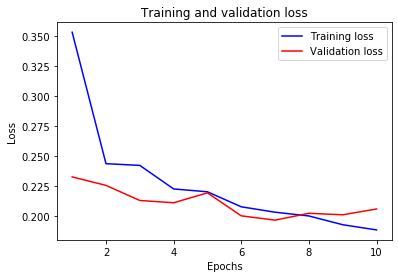

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

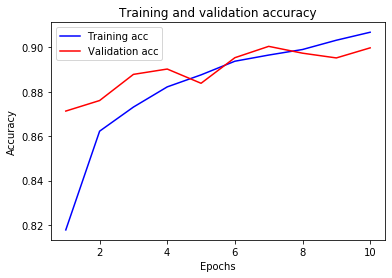

In [74]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()